In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
#from keras_retinanet.preprocessing.coco import CocoGenerator
from keras_retinanet.preprocessing.csv_rtsd_generator import CSVRTSDGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


## Load RetinaNet model

In [4]:
model = keras.models.load_model('D:\\CV\\snapshots\\152\\resnet50_csv_rtsd_50.h5', custom_objects=custom_objects)
#print(model.summary())

C:\Users\Юрий\AppData\Roaming\Python\Python35\site-packages\keras\models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
from keras_retinanet import losses
from keras_retinanet import layers

# compile model
model.compile(
        loss={
            'regression'    : losses.smooth_l1(),
            'classification': losses.focal()
        },
        optimizer=keras.optimizers.adam(lr=1e-5, clipnorm=0.001)
    )

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Output "nms" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "nms" during training.
  # Remove the CWD from sys.path while we load stuff.


## Initialize data generators

In [6]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

# create a generator for testing data
val_generator = CSVRTSDGenerator(
    'D:\\CV\\test\\test_gt.csv',
    'D:\\CV\\test\\numbers_to_classes.csv',
    val_image_data_generator,
    'D:\\CV\\test\\test\\',
)
index = 0

## Run detection on example

processing time:  0.20114874839782715


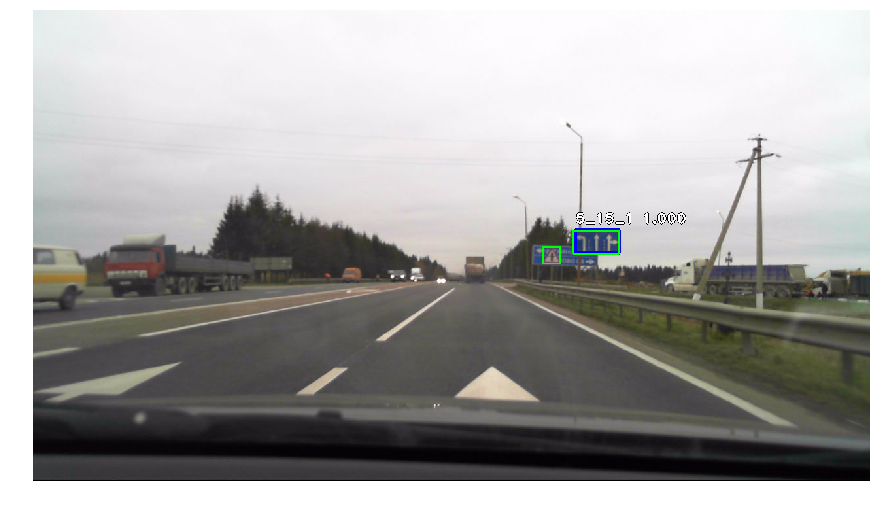

In [42]:
# load image
image = val_generator.load_image(index)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = val_generator.preprocess_image(image)
image, scale = val_generator.resize_image(image)
annotations = val_generator.load_annotations(index)
index += 1

# process image
start = time.time()
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

# correct for image scale
detections[0, :, :4] /= scale

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.1:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(val_generator.label_to_name(label), score)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
# visualize annotations
for annotation in annotations:
    label = int(annotation[4])
    b = annotation[:4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
    caption = "{}".format(val_generator.label_to_name(label))
    #cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    #cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [43]:
def detect_and_draw(image):
    
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = val_generator.preprocess_image(image)
    image, scale = val_generator.resize_image(image)

    # process image    
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

    # correct for image scale
    detections[0, :, :4] /= scale

    # visualize detections
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        if score < 0.3:
            continue
        b = detections[0, idx, :4].astype(int)
        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
        caption = "{} {:.3f}".format(val_generator.label_to_name(label), score)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
        
    return draw

In [ ]:

# Import the required modules
%pylab inline 
import cv2
from IPython.display import clear_output


# Grab the input device, in this case the webcam
# You can also give path to the video file
vid = cv2.VideoCapture("D:\\#ML\\data\\FILE170315-092607.MP4")
frameRate = vid.get(5) #frame rate
# Put the code in try-except statements
# Catch the keyboard exception and 
# release the camera device and 
# continue with the rest of code.

width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))   # float
height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)) # float
    
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('D:\\#ML\\data\\output.MOV',fourcc, 20.0, (width,height))

try:
    while(True):
        # Capture frame-by-frame
        frameId = vid.get(1) #current frame number
        ret, frame = vid.read()
        if not ret:
            # Release the Video Device if ret is false
            vid.release()
            out.release()
            # Message to be displayed after releasing the device
            print ("Released Video Resource")
            break
        
        #if (frameId % math.floor(frameRate) != 0):
        #    continue
            
        # Convert the image from OpenCV BGR format to matplotlib RGB format
        # to display the image
        frame = detect_and_draw(frame)
        
        out.write(frame)
        #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Turn off the axis
        
        #figure(figsize=(15, 15))
        #axis('off')
        # Title of the window
        #title("Input Stream")
        # Display the frame        
        #imshow(frame)        
        #show()
        # Display the frame until new frame is available
        #clear_output(wait=True)
except KeyboardInterrupt:
    # Release the Video Device
    vid.release()
    out.release()
    # Message to be displayed after releasing the device
    print ("Released Video Resource")

Populating the interactive namespace from numpy and matplotlib


In [154]:
%%html
<!-- TODO -->
<iframe width="1024" height="768" src="https://www.youtube.com/embed/2TT1EKPV_hc" frameborder="0" allowfullscreen></iframe>